In [64]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import cv2
from pose_estimation import utils

from matplotlib.offsetbox import (TextArea, DrawingArea, OffsetImage,
                                  AnnotationBbox)


In [65]:
from pose_estimation.ml import Movenet
movenet = Movenet('movenet_thunder')

# Gọi hàm nhận dạng của movenet nhiều lần để cải thiện độ chính xác nhận dạng khung xương


def detect(input_tensor, inference_count=3):
  """Runs detection on an input image.
 
  Args:
    input_tensor: A [height, width, 3] Tensor of type tf.float32.
    inference_count: Số lần lặp.
 
  Returns:
    A Person entity detected by the MoveNet.SinglePose.
  """
  image_height, image_width, channel = input_tensor.shape

  # Detect pose using the full input image
  movenet.detect(input_tensor.numpy(), reset_crop_region=True)

  # Repeatedly using previous detection result to identify the region of
  # interest and only croping that region to improve detection accuracy
  for _ in range(inference_count - 1):
    person = movenet.detect(input_tensor.numpy(),
                            reset_crop_region=False)

  return person


In [66]:
def evaluate_model(interpreter, X, y_true):
  """Evaluates the given TFLite model and return its accuracy."""
  input_index = interpreter.get_input_details()[0]["index"]
  output_index = interpreter.get_output_details()[0]["index"]

  # Run predictions on all given poses.
  for i in range(len(y_true)):
    # Pre-processing: add batch dimension and convert to float32 to match with
    # the model's input data format.
    test_image = X[i: i + 1].astype('float32')  # [i: i + 1]: truy cập 1 row của dataframe (mỗi ảnh là 1 row của dataframe)
    interpreter.set_tensor(input_index, test_image)

    # Run inference.
    interpreter.invoke()

    # Post-processing: remove batch dimension and find the class with highest
    # probability.
    output = interpreter.tensor(output_index)

    predicted_label = np.argmax(output()[0])
    y_pred.append(predicted_label)

    s = ""
    for i in range(len(output()[0])):
      s += f"{class_names[i]}: {round(output()[0][i]*100/output()[0].sum(), 5)} %\n"
    listNotes.append(s)

    print(f"\nKet luan: {class_names[predicted_label]}")
    print('\n')

  # Compare prediction results with ground truth labels to calculate accuracy.
  # y_pred = keras.utils.to_categorical(y_pred)
  return accuracy_score(y_true, y_pred)

class_names = []
with open('pose_labels.txt','r') as f:
  for line in f.readlines():
    class_names.append(line.strip())

print(class_names)

# TEST
# Extract pose from image
listPoses = []
listPaths = ['Image\\Thang lung\\output2_0023.png',
              'Image\\Gu lung\\vid_5_0091.png', 'Image\\Ngoi xom\\vid_3_0001.png']
y_true = [6, 1, 4]   # index of label true
y_pred = []

listPersons = []
listImages = []
listNotes = []

for image_path in listPaths:
  image = tf.io.read_file(image_path)
  image = tf.io.decode_jpeg(image)
  person = detect(image)

  listImages.append(image)
  listPersons.append(person)
  
  listLandmarks = []
  for keypoint in person.keypoints:
    listLandmarks.extend([keypoint.coordinate.x, keypoint.coordinate.y, keypoint.score])
  
  listPoses.append(listLandmarks)

# Evaluate the accuracy of the converted TFLite model
classifier_interpreter = tf.lite.Interpreter(model_path='pose_classifier.tflite')
    
classifier_interpreter.allocate_tensors()

X_test = pd.DataFrame(listPoses)  # from list to row dataframe
# print(X_test)

print('Accuracy of TFLite model: %s' %
      evaluate_model(classifier_interpreter, X_test, y_true))



['Gac chan', 'Gu lung', 'Nga lung', 'Nghieng nguoi', 'Ngoi xom', 'Ngu gat', 'Thang lung', '_']

Ket luan: Thang lung



Ket luan: Gu lung



Ket luan: Ngoi xom


Accuracy of TFLite model: 1.0


In [67]:
df = pd.DataFrame([[2, 3,4,5], [3, 4,5,3]])
df[0:1]

,0,1,2,3
0,2,3,4,5


In [68]:
print(listNotes)

['Gac chan: 0.0 %\nGu lung: 0.01273 %\nNga lung: 0.0 %\nNghieng nguoi: 0.0 %\nNgoi xom: 0.0 %\nNgu gat: 0.0 %\nThang lung: 99.98727 %\n_: 0.0 %\n', 'Gac chan: 0.00113 %\nGu lung: 99.97092 %\nNga lung: 0.0 %\nNghieng nguoi: 6e-05 %\nNgoi xom: 0.0 %\nNgu gat: 0.0 %\nThang lung: 0.02789 %\n_: 0.0 %\n', 'Gac chan: 0.0 %\nGu lung: 2e-05 %\nNga lung: 0.0 %\nNghieng nguoi: 0.0 %\nNgoi xom: 99.99999 %\nNgu gat: 0.0 %\nThang lung: 0.0 %\n_: 0.0 %\n']


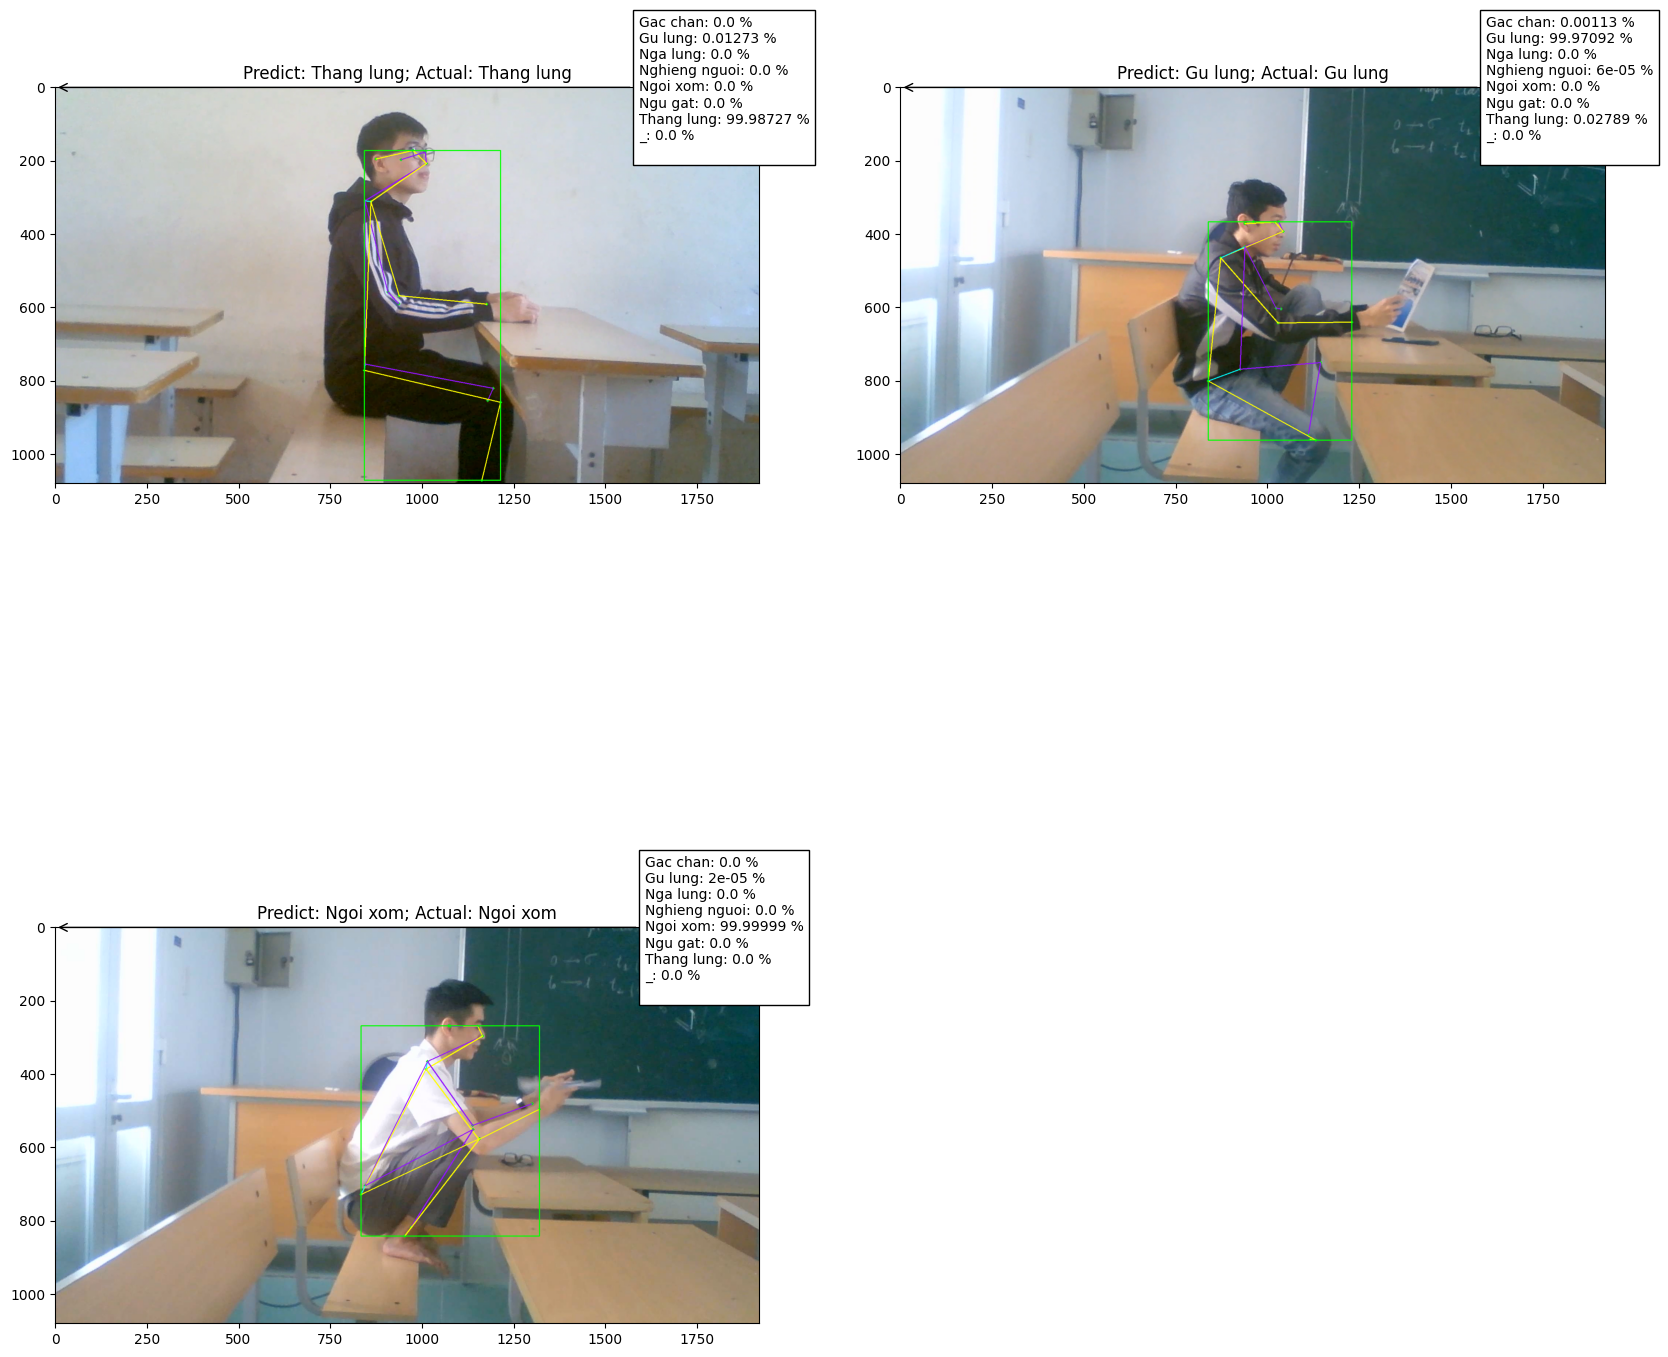

In [84]:
IMAGE_PER_ROW = 2

# Plot the incorrectly predicted images
row_count = len(y_true) // IMAGE_PER_ROW + 1
fig = plt.figure(figsize=(10 * IMAGE_PER_ROW, 10 * row_count))

for i, image in enumerate(listImages):
  ax = fig.add_subplot(row_count, IMAGE_PER_ROW, i + 1)

  image = image.numpy()

  plt.title("Predict: %s; Actual: %s"
            % (class_names[y_pred[i]], class_names[y_true[i]]))
  
   # Draw the detection result on top of the image.
  image_np = utils.visualize(image, [listPersons[i]])

  # Plot the image with detection results.
  # height, width, channel = image.shape
  # aspect_ratio = float(width) / height
  # # fig, ax = plt.subplots(figsize=(12 * aspect_ratio, 12))

  offsetbox = TextArea(listNotes[i])

  ab = AnnotationBbox(offsetbox, (0.5, 0.7),
                      xybox=(0.95, 0.5),
                      # xycoords='data',
                      boxcoords=("axes fraction", "data"),
                      # box_alignment=(0., 0.5),
                      arrowprops=dict(arrowstyle="->"))
  ax.add_artist(ab)
  
  im = ax.imshow(image_np)

plt.show()
